In [1]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
!pip install lxml


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\rouxe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Importation des librairies
# from Base_de_données.ws_fonctions import *

# from fonctions_1_nettoyage import *
# from fonctions_2_graph import *

# import seaborn as sns #pas besoin si utilise fonctions
import matplotlib.pyplot as plt

# Regression
import statsmodels.api as sm
from statsmodels.formula.api import rlm 

In [17]:
import os

# Importation des fichiers python (contenant des fonctions) crées dans le cadre des 3 parties du projet :

for f in os.listdir('Base_de_données'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from Base_de_données.{module_name} import *")


for f in os.listdir('Analyse_descriptive'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from Analyse_descriptive.{module_name} import *")


for f in os.listdir('Modele'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from Modele.{module_name} import *")


## Création de la base de données

### Webscrapping AlloCiné

In [19]:
base_films = get_base_films(2010,2011)

nombre de films récupérés :  475
nombre de films récupérés :  518


### Ajout et création de variables

In [20]:
# Ajout du genre des réalisateurs
table_avec_genre = get_genre_individuel(base_films, 'auteur')

# Aperçu du nb de réalisateurs m vs f
table_avec_genre['genre_ind'].value_counts()


genre_ind
m      629
f      102
m,f     33
f,m      9
Name: count, dtype: int64

In [21]:
table_avec_genre.head()

,genre_ind,titre,identifiant,date,durée,auteur,spectateur,presse,genre1,genre2,genre3
0,m,4h44 Dernier jour sur terre,193915,19 décembre 2012,1h 22min,Abel Ferrara,"2,2","3,3",Drame,Science Fiction,
1,m,Very Bad Cops,144195,27 octobre 2010,1h 47min,Adam McKay,"2,5","3,3",Action,Comédie,
2,f,"The Last Son, la malédiction",187541,23 novembre 2011,1h 35min,Agnès Merlet,"2,8","2,8",Fantastique,Thriller,
3,f,Sous la ville,190423,10 octobre 2012,2h 25min,Agnieszka Holland,"3,7","3,6",Drame,Guerre,
4,"m,f",Le Havre,173542,21 décembre 2011,1h 33min,Aki Kaurismäki,"3,1","4,1",Drame,,


In [22]:
# Transformation des types de films en variables dummy 
dummies1 = pd.get_dummies(table_avec_genre['genre1'], prefix='genre')
dummies2 = pd.get_dummies(table_avec_genre['genre2'], prefix='genre')
dummies3 = pd.get_dummies(table_avec_genre['genre3'], prefix='genre')

dummies1 = dummies1.astype(int)
dummies2 = dummies2.astype(int)
dummies3 = dummies3.astype(int)

dummies_sum = dummies1.add(dummies2, fill_value=0).add(dummies3, fill_value=0)
dummies_sum = dummies_sum.drop(columns=['genre_'])

df = pd.concat([table_avec_genre, dummies_sum], axis=1)
print('nombre de films pris en compte :', len(df))

nombre de films pris en compte : 773


In [23]:
# Conversion des notes en décimale
table_avec_genre['spectateur'] = table_avec_genre['spectateur'].apply(mise_en_forme_decimale)
table_avec_genre['presse'] = table_avec_genre['presse'].apply(mise_en_forme_decimale)

In [24]:
# Création variable : différence de notation entre spectateur et presse
table_avec_genre['diff_notation'] = table_avec_genre['spectateur']-table_avec_genre['presse']
table_avec_genre.head()


,genre_ind,titre,identifiant,date,durée,auteur,spectateur,presse,genre1,genre2,genre3,diff_notation
0,m,4h44 Dernier jour sur terre,193915,19 décembre 2012,1h 22min,Abel Ferrara,2.2,3.3,Drame,Science Fiction,,-1.1
1,m,Very Bad Cops,144195,27 octobre 2010,1h 47min,Adam McKay,2.5,3.3,Action,Comédie,,-0.8
2,f,"The Last Son, la malédiction",187541,23 novembre 2011,1h 35min,Agnès Merlet,2.8,2.8,Fantastique,Thriller,,0.0
3,f,Sous la ville,190423,10 octobre 2012,2h 25min,Agnieszka Holland,3.7,3.6,Drame,Guerre,,0.1
4,"m,f",Le Havre,173542,21 décembre 2011,1h 33min,Aki Kaurismäki,3.1,4.1,Drame,,,-1.0


In [25]:
table_avec_genre = get_annee(table_avec_genre, 'date')

In [26]:
# Conversion de la durée en minutes
table_avec_genre['durée'] = table_avec_genre['durée'].astype('string')
table_avec_genre['duree_min'] = table_avec_genre['durée'].apply(duree_en_minutes)

In [ ]:
# Exportation en CSV => mettre en commentaire lors du rendu afin que cela soit toujours le même CSV qui soit utilisé par la suite

## Quelques graphes.... Analyse descriptive

Dropdown(description='Genre :', index=11, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aventu…

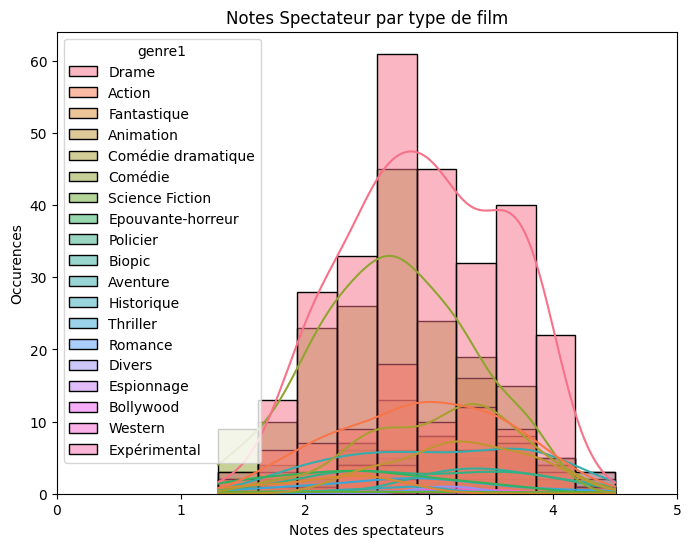

In [27]:
graphique_genre_film(table_avec_genre)  

Dropdown(description='Genre du film :', index=9, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', …

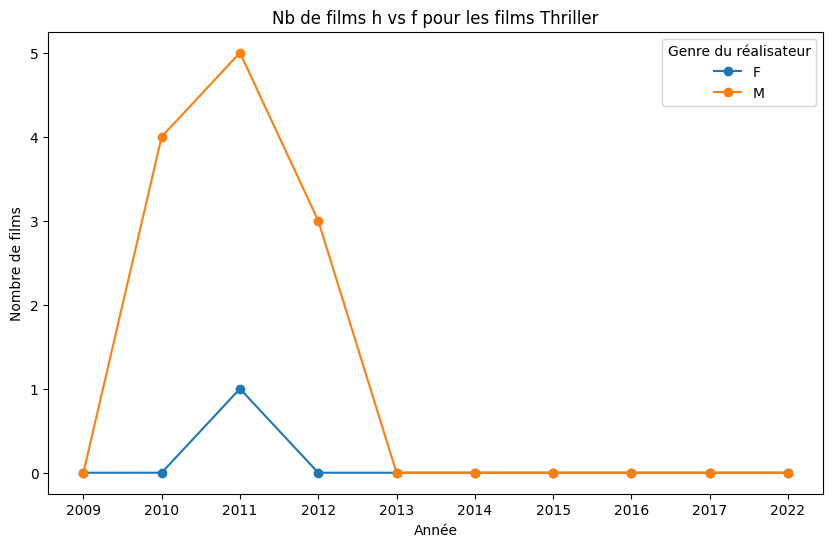

In [28]:
graphique_h_f(table_avec_genre)

## Test de modèles sur la différence de notation

### ANOVA (sur premier genre)

### Regression

- Notes spectateurs

In [122]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['spectateur']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             spectateur   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     15.89
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           2.22e-19
Time:                        19:22:41   Log-Likelihood:                -256.63
No. Observations:                 296   AIC:                             531.3
Df Residuals:                     287   BIC:                             564.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.71

- Notes presse

In [124]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['presse']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 presse   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     17.38
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           4.49e-21
Time:                        19:23:34   Log-Likelihood:                -216.55
No. Observations:                 296   AIC:                             451.1
Df Residuals:                     287   BIC:                             484.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.29

- Différences de notations

In [125]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['diff_notation']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          diff_notation   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.929
Date:                Sun, 03 Nov 2024   Prob (F-statistic):             0.0556
Time:                        19:25:00   Log-Likelihood:                -226.63
No. Observations:                 296   AIC:                             471.3
Df Residuals:                     287   BIC:                             504.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.57

In [126]:
# test robuste à l'hétéroscédasticité ?
model = rlm("diff_notation ~ duree_min + genre_Action + genre_Animation+genre_Policier+genre_Fantastique+genre_Drame+genre_Aventure", data=df).fit()
print(model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          diff_notation   No. Observations:                  296
Model:                            RLM   Df Residuals:                      288
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Nov 2024                                         
Time:                        19:25:14                                         
No. Iterations:                    16                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5961      0.18